<a href="https://colab.research.google.com/github/SilahicAmil/NLP/blob/main/Financial_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial Sentiment Analysis

https://www.kaggle.com/sbhatti/financial-sentiment-analysis

In [97]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# SciKit
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Keras
import keras
from keras.layers import Embedding, TextVectorization
from keras.metrics import categorical_accuracy

In [2]:
full_data = pd.read_csv("/content/drive/MyDrive/Random_Sentiment_Analysis/data.csv")
full_data.head()

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,positive
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,2,"For the last quarter of 2010 , Componenta 's n...",positive
3,3,According to the Finnish-Russian Chamber of Co...,neutral
4,4,The Swedish buyout firm has sold its remaining...,neutral


In [12]:
full_data.Sentiment.value_counts()
full_data_copy = full_data.copy()

# Mapping Dataset

In [14]:
mappings = {"neutral": 2, "positive": 1, "negative": 0}

full_data_copy = full_data_copy.replace({"Sentiment": mappings})
full_data_copy.head()

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,1
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,2,"For the last quarter of 2010 , Componenta 's n...",1
3,3,According to the Finnish-Russian Chamber of Co...,2
4,4,The Swedish buyout firm has sold its remaining...,2


# Shuffle Data for the lulz

In [15]:
shuffled_full_data = full_data_copy.sample(frac=1, random_state=42)
shuffled_full_data.head()

,Unnamed: 0,Sentence,Sentiment
4584,4584,A few employees would remain at the Oulu plant...,2
177,177,Comparable net sales are expected to increase ...,1
167,167,"Tesla is recalling 2,700 Model X cars: https:/...",0
5585,5585,Finnish software developer Done Solutions Oyj ...,1
2339,2339,Compagnie de Financement Foncier - Is to issue...,2


# Train Test Validation Sets

In [17]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(shuffled_full_data["Sentence"].to_numpy(),
                                                                              shuffled_full_data["Sentiment"].to_numpy(),
                                                                              test_size=0.2,
                                                                              random_state=42)

In [19]:
len(train_sentences), len(test_sentences)

(4673, 1169)

In [20]:
train_sentences[:5]

array(['ADPnews - Dec 23 , 2009 - Norwegian financial services group SpareBank 1 Gruppen AS OSL : SBGRP said its board of directors appointed today Jarle Haug managing director of its claims collection subsidiary SpareBank 1 Gruppen Finans',
       'Finnish telecoms software developer Tecnomen Oyj said on December 5 , 2006 it won a $ 3.3 mln ( 2.5 mln euro ) order to supply an expansion of the charging and messaging systems for the mobile and fixed networks of Brasil Telecom .',
       'Royal Mail, Johnson Matthey lead FTSE lower',
       'This will be done domestically and in neighboring markets , both organically and through acquisitions .',
       'As capacity was cut with 1.4 % , the passenger load factor was down 7.8 percentage points .'],
      dtype=object)

In [21]:
test_sentences[:5]


array(["`` We are very pleased to be working with Fujitsu and NTT DoCoMo to advance the progress of LTE , '' said Juergen Walter , Head of Converged Core , Nokia Siemens Networks .",
       "`` We 've been feeling quite positive about the region as a whole .",
       "Tekla Structures 16 is ` all about you and your team ' and compatible with the Windows 7 operating system .",
       'Yahoo stock is up to $36.46 as the bidding war picks up for the company https://t.co/JDNZXDCMkl $YHOO https://t.co/HmOegfHgvn',
       'The earnings in the comparative period included a capital gain of EUR 8mn from the sale of OMX shares .'],
      dtype=object)

# Vectorization Prep

In [65]:
# 98k sentences
sent_lens = [len(i.split()) for i in train_sentences]

In [66]:
# Screw it just gonna round up to 21
round(sum([len(i.split()) for i in train_sentences]))/len(train_sentences)


20.990584207147442

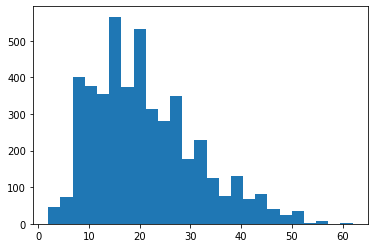

In [67]:
plt.hist(sent_lens, bins=25);

In [69]:
MAX_SENT_LEN = int(np.percentile(sent_lens, 95))
MAX_SENT_LEN

42

# Vectorization

In [82]:
MAX_VOCAB_LEN = 12_000


txt_vect = TextVectorization(max_tokens=MAX_VOCAB_LEN,
                             output_mode="int",
                             pad_to_max_tokens=True,
                             output_sequence_length=MAX_SENT_LEN)

In [83]:
txt_vect.adapt(train_sentences)

In [84]:
words_in_vocab = txt_vect.get_vocabulary()
len(words_in_vocab)

11321

# Functions

In [116]:
def compile_model(model):
  model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  
def fit_model(model, epochs):
  model.fit(train_sentences,
            train_labels,
            epochs=epochs,
            validation_data=(test_sentences, test_labels))

In [86]:
# Ripping eval function from other project since im lazy

def calculate_results(y_true, y_pred):
  """
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_result

In [87]:
def acc_loss(model):
  loss, accuracy = model.evaluate(test_sentences, test_labels, verbose=1)
  print(f"Loss: {loss}\nAccuracy: {accuracy}")

## Embedding Model

In [105]:
Embedding = keras.layers.Embedding(input_dim=MAX_VOCAB_LEN,
                                      output_dim=128,
                                      input_length=MAX_SENT_LEN)

In [111]:
tf.random.set_seed(42)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

X = txt_vect(inputs)

X = Embedding(X)

# Pooling Layer POGGERS
X = keras.layers.GlobalAveragePooling1D()(X)

# Output
outputs = keras.layers.Dense(1, activation="softmax")(X)

# Create Model
model_0 = tf.keras.Model(inputs, outputs, name="Baseline_Model")

In [112]:
model_0.summary()

Model: "Baseline_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 42)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 42, 128)           1536000   
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,536,129
Trainable params: 1,536,129


In [117]:
compile_model(model_0)

In [118]:
hist_0 = fit_model(model_0, 10)

Epoch 1/10
147/147 [==============================] - 1s 6ms/step - loss: -173.0960 - accuracy: 0.3156 - val_loss: -184.5344 - val_accuracy: 0.3225
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: -196.5414 - accuracy: 0.3156 - val_loss: -209.0421 - val_accuracy: 0.3225
Epoch 3/10
147/147 [==============================] - 1s 4ms/step - loss: -222.0612 - accuracy: 0.3156 - val_loss: -235.5487 - val_accuracy: 0.3225
Epoch 4/10
147/147 [==============================] - 1s 5ms/step - loss: -250.1338 - accuracy: 0.3156 - val_loss: -264.6568 - val_accuracy: 0.3225
Epoch 5/10
147/147 [==============================] - 1s 4ms/step - loss: -279.4419 - accuracy: 0.3156 - val_loss: -294.6832 - val_accuracy: 0.3225
Epoch 6/10
147/147 [==============================] - 1s 5ms/step - loss: -310.7218 - accuracy: 0.3156 - val_loss: -327.2142 - val_accuracy: 0.3225
Epoch 7/10
147/147 [==============================] - 1s 5ms/step - loss: -344.7869 - accuracy: 0.3156 - val_los

In [119]:
acc_loss(model_0)

37/37 [==============================] - 0s 3ms/step - loss: -482.6657 - accuracy: 0.3225
Loss: -482.6656799316406
Accuracy: 0.3224978744983673
